In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )

# translate covariance to points, center on mean, and plot
def plot( data, res, mus, covs, it ):
    ax = plt.subplot()
    # scatter plot clusters based on greater responsibility
    cluster1 = data[np.where(res[:, 0] > res[:, 1])]
    cluster2 = data[np.where(res[:, 0] <= res[:, 1])]
    ax.scatter(cluster2[:, 0], cluster2[:, 1], color='k')
    ax.scatter(cluster1[:, 0], cluster1[:, 1], color='y')
    # scatter plot mean of each cluster
    ax.scatter(mus[0, 1], mus[1, 1], color='k', s=200)
    ax.scatter(mus[0, 0], mus[1, 0], color='y', s=200)
    # plot covariance ellipses
    pts_1 = cov_to_pts(covs[0]).T + mus[:, 0]
    pts_2 = cov_to_pts(covs[1]).T + mus[:, 1]
    line_1 = ax.plot(pts_1[:,0], pts_1[:,1], color='y', label='Class 1')
    line_2 = ax.plot(pts_2[:,0], pts_2[:,1], color='k', label='Class 2')
    plt.xlim(-3, 3)
    plt.ylim(-40, 30)
    plt.legend()
    plt.title('Iter %d' % it) 
    plt.show()

mus = np.asarray( [[-1.17288986, -0.11642103],
                   [-0.16526981,  0.70142713]])
 
covs = list()
covs.append( 
    np.asarray([[ 0.74072815,  0.09252716],
                [ 0.09252716,  0.5966275 ]]) )
covs.append( 
    np.asarray([[ 0.39312776, -0.46488887],
                [-0.46488887,  1.64990767]]) )
 
mws = [ 0.68618439, 0.31381561 ]

mat = loadmat('old_faithful.mat')
data = mat['data']

K = len(mws)
N = data.shape[0]

data = data - data.mean(axis=0)

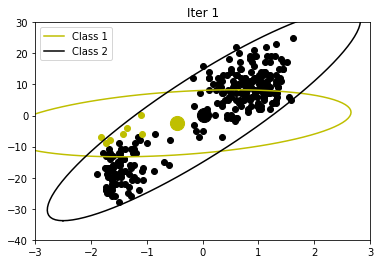

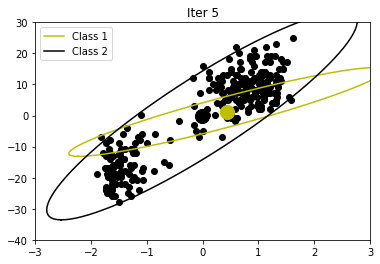

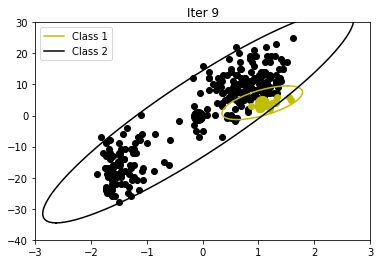

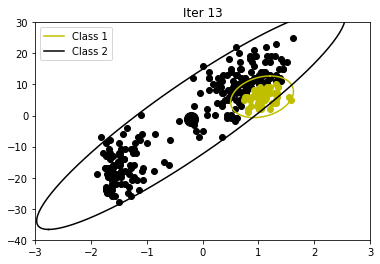

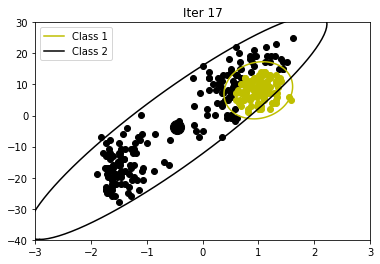

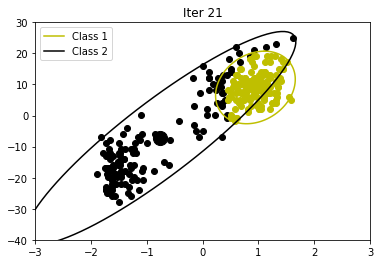

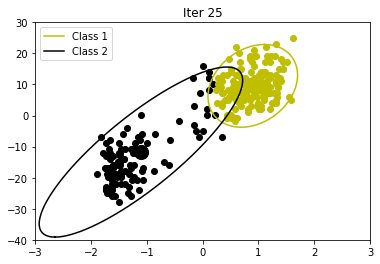

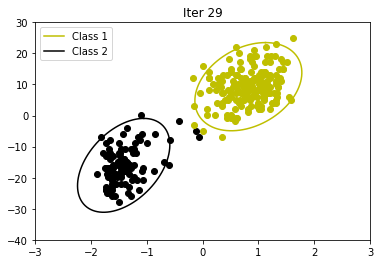

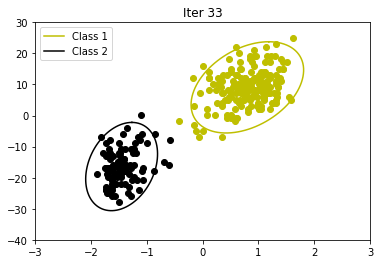

Converged after 37 iterations


In [2]:
r = np.zeros((N,K))
converged = False
z = 1
while not converged:
    # save previous covs and mus for convergence comparison
    prev_covs = covs
    prev_mus = mus
    
    # update responsibilities (rik)
    for i in range(N):
        for k in range(K):
            r[i, k] = multivariate_normal.pdf(data[i], mus[:,k], covs[k]) * mws[k]
    norm = np.sum(r, axis=1).reshape(r.shape[0], 1)
    r = r / norm

    # update effective points and mixing weights (r_k / mws)
    N_k = np.sum(r, axis=0)
    mws = N_k / N
    
    # update covariances
    X0 = data - mus[:,0]
    X1 = data - mus[:,1]
    covs[0] = np.dot((r[:,0:1] * X0).T, X0) / N_k[0]
    covs[1] = np.dot((r[:,1:2] * X1).T, X1) / N_k[1]

    # update means
    mus = np.dot(data.T, r) / N_k

    if z in range(1, 34, 4):
        plot(data, r, mus, covs, z)
        
    cov_match = np.isclose(covs, prev_covs)
    mus_match = np.isclose(mus, prev_mus)
    converged = cov_match.all() and mus_match.all()
    z += 1
print('Converged after %d iterations' % z)